![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz


In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [5]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

De acuerdo a la información proporcionada, en la estación de invierno es donde se presta una cantidad menor de bicicletas respecto a las otras estaciones. Caso contrario ocurre en la estación de verano donde concentra la mayor cantidad de préstamo de bicicletas.

In [7]:
def descriptive_analysis(data, group_column, target_column):
   
    grouped_data = data.groupby(group_column)[target_column] 
    descriptive_stats = grouped_data.agg(
        max_value=('max'),
        min_value=('min'),
        p25=(lambda x: x.quantile(0.25)),
        p50=(lambda x: x.quantile(0.5)),  # Percentil 50 (mediana)
        p75=(lambda x: x.quantile(0.75))
    )
    
    return descriptive_stats
    
season_analysis = descriptive_analysis(bikes, 'season', 'total')

# Mostrar los resultados
print("Análisis descriptivo de 'season' en función de 'total':")
print(season_analysis)

Análisis descriptivo de 'season' en función de 'total':
        max_value  min_value   p25    p50    p75
season                                          
1             801          1  24.0   78.0  164.0
2             873          1  49.0  172.0  321.0
3             977          1  68.0  195.0  347.0
4             948          1  51.0  161.0  294.0


Al revisar el estadístico del percentil, queda marcado el comportamiento en la estación de invierno que el 50% de la cantidad de prestamos son menores o iguales a 78 bicicletas. Es un número muy bajo comparado con las otras estaciones.

In [9]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [10]:
season_analysis = descriptive_analysis(bikes, 'hour', 'total')

# Mostrar los resultados
print("Análisis descriptivo de 'season' en función de 'total':")
print(season_analysis)

Análisis descriptivo de 'season' en función de 'total':
      max_value  min_value     p25    p50     p75
hour                                             
0           283          2   24.00   41.0   74.50
1           168          1   11.00   19.0   46.00
2           119          1    5.00   11.0   32.00
3            66          1    3.00    6.0   15.00
4            28          1    3.00    6.0    9.00
5            57          1    8.00   19.0   29.00
6           213          1   24.50   75.0  118.00
7           596          1   63.00  208.0  334.00
8           839          8  133.50  392.0  563.50
9           414         14  161.00  217.0  294.50
10          539         17  106.00  149.0  218.50
11          647         10  123.00  183.0  265.50
12          757          3  157.00  234.5  332.00
13          729         11  154.00  226.5  329.00
14          730         12  144.00  212.0  311.25
15          724          7  154.00  232.0  331.00
16          783         11  211.75  309.5  4

En promedio las horas donde hay mas concetraciones de préstamo de bicicletas son a las 8, 16, 17 18 y 19 horas. Esta estimación es ratificada con la estimación de los percentiles en especial del 50% donde ratifica la afirmación inicial.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

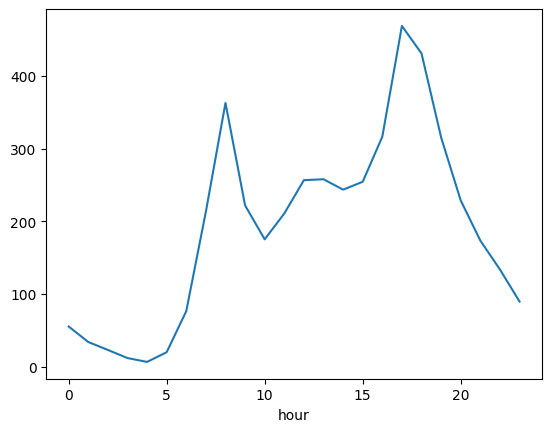

In [11]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

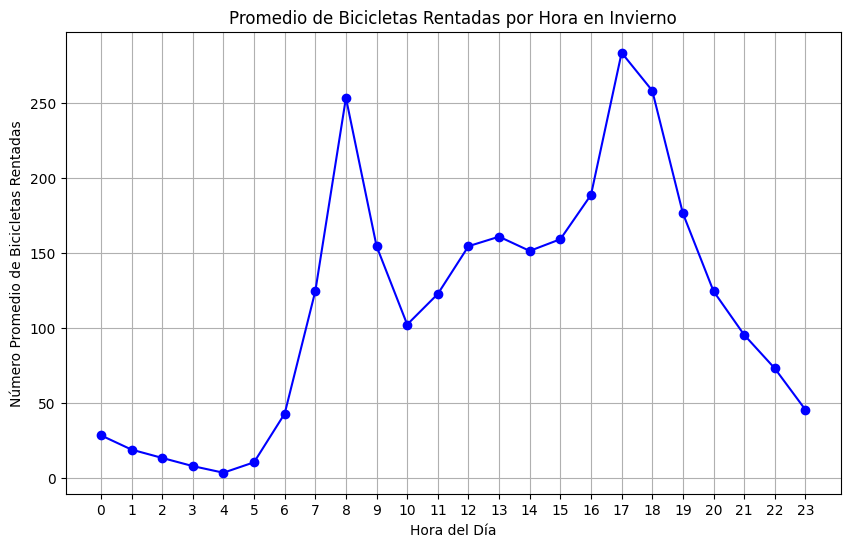

In [12]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
import matplotlib.pyplot as plt

invierno_bikes = bikes[bikes['season'] == 1]
average_rentals_per_hour = invierno_bikes.groupby('hour')['total'].mean()

# Gráfica
plt.figure(figsize=(10, 6))
average_rentals_per_hour.plot(kind='line', color='blue', marker='o', linestyle='-')
plt.title('Promedio de Bicicletas Rentadas por Hora en Invierno')
plt.xlabel('Hora del Día')
plt.ylabel('Número Promedio de Bicicletas Rentadas')
plt.grid(True)
plt.xticks(range(0, 24))  # Mostrar cada hora en el eje X
plt.show()


Podemos observar en la gráfica que, durante el invierno, las horas de mayor demanda en el préstamo de bicicletas ocurren a las 8:00, 17:00 y 18:00 horas. Este patrón sugiere una fuerte relación con los horarios de inicio y finalización de la jornada laboral, reflejando el comportamiento de movilidad de las personas en su rutina diaria.

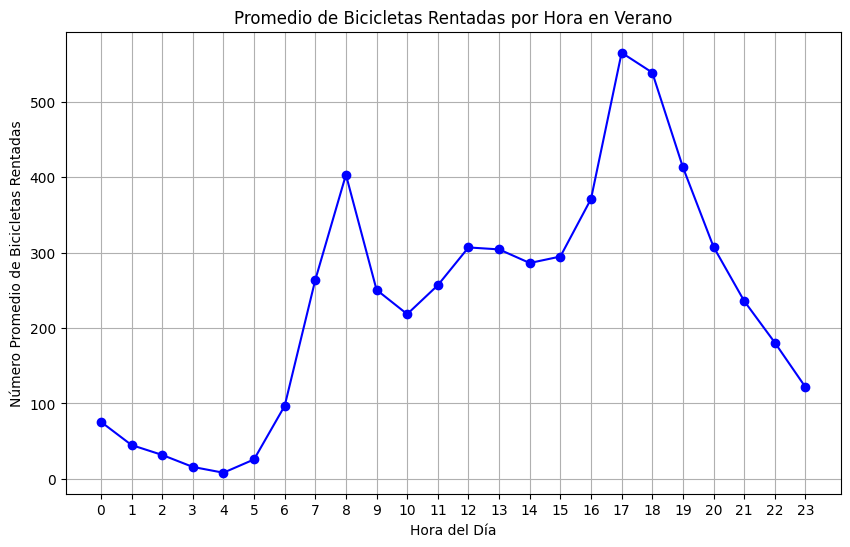

In [14]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 

verano_bikes = bikes[bikes['season'] == 3]
average_rentals_per_hour = verano_bikes.groupby('hour')['total'].mean()

# Gráfica
plt.figure(figsize=(10, 6))
average_rentals_per_hour.plot(kind='line', color='blue', marker='o', linestyle='-')
plt.title('Promedio de Bicicletas Rentadas por Hora en Verano')
plt.xlabel('Hora del Día')
plt.ylabel('Número Promedio de Bicicletas Rentadas')
plt.grid(True)
plt.xticks(range(0, 24))  # Mostrar cada hora en el eje X
plt.show()


Al igual que en invierno, las horas de mayor demanda en el préstamo de bicicletas se registran a las 8:00, 17:00 y 18:00 horas, lo que sugiere una fuerte relación con los horarios de inicio y finalización de la jornada laboral. Este patrón refleja el comportamiento de movilidad diaria de las personas. Sin embargo, a diferencia del invierno, la demanda de préstamos de bicicletas es notablemente mayor, lo que podría estar influenciado por condiciones climáticas más favorables u otros factores estacionales.


### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a un conjunto de train de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [57]:
# Celda 3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

X = bikes[['season', 'hour']]
y = bikes['total']

X = pd.get_dummies(X, columns=['season'], drop_first=True)

# K=5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Almacenamos cada fold
intercepts = []
coefs = []

# Validación cruzada
for train_index, test_index in kf.split(X):
    # Separar datos en train y test para este fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Entrenar modelo
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Guardar coeficientes del modelo
    intercepts.append(model.intercept_)
    coefs.append(model.coef_)

# Resultados
mean_intercept = np.mean(intercepts)
mean_coefs = np.mean(coefs, axis=0)

print("\nIntercepto promedio:", mean_intercept)
print("Coeficientes promedio:")
for feature, coef in zip(X.columns, mean_coefs):
    print(f"{feature}: {coef}")

y_pred_lr = model.predict(X_test) 
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"\nRMSE - Regresión Lineal: {rmse_lr}")
print(f"R² - Regresión Lineal: {r2_lr}")


Intercepto promedio: -6.4221721935743
Coeficientes promedio:
hour: 10.544771341076515
season_2: 100.3141227903202
season_3: 119.46310150459738
season_4: 84.0830511948015

RMSE - Regresión Lineal: 156.15576711308222
R² - Regresión Lineal: 0.24615855846653723


#### Interpretando los coeficientes:
•	El intercepto de -6.42 es el valor esperado de total cuando hour = 0 y es la temporada de referencia (season_1).

•	hour = 10.54: cada hora adicional aumenta el total en 10.54 unidades.

•	season_2 (primavera) = 100.31: si la temporada es season_2, el total aumenta en 100.31 unidades respecto a la temporada de referencia (season_1).

•	season_3 (verano) = 119.46 : si la temporada es season_3, el total aumenta en 119.46 unidades respecto a la temporada de referencia.

•	season_4 (otoño) = 84.08 : si la temporada es season_4, el total aumenta en 84.08 unidades respecto a la temporada de referencia.

Nota: temporada de referencia es season 1 y el total significa nro. total de bicicletas alquiladas

La principal limitación de utilizar un modelo de regresión lineal en este caso es la suposición de que la relación entre las variables predictoras y la variable objetivo es estrictamente lineal. Sin embargo, es posible que existan patrones más complejos o comportamientos no lineales en los datos, especialmente si la demanda varía en función de factores estacionales o eventos específicos. Estos patrones pueden ser estacionarios, repitiéndose en ciertos períodos, lo que sugiere que un modelo más flexible, como árboles de decisión o modelos de series temporales, podría capturar mejor estas dinámicas.


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [49]:
# Celda 4

bikes['hour'] = bikes.index.hour
data = bikes[['hour', 'season', 'total']]

# Primera división
data['node_1'] = np.where(data['hour'] < 12, 'morning', 'afternoon')

# Analizar promedios de 'total' en cada grupo
print(data.groupby('node_1')['total'].mean())

# Segunda división
data['node_2'] = np.where((data['node_1'] == 'morning') & (data['season'] == 1), 'morning_winter',
                 np.where((data['node_1'] == 'morning') & (data['season'] == 2), 'morning_spring',
                 np.where((data['node_1'] == 'afternoon') & (data['season'] == 3), 'afternoon_summer',
                 'other')))

# Analizar promedios de 'total' en los subgrupos
print("\n")
print(data.groupby('node_2')['total'].mean())

# Tercera división
data['node_3'] = np.where((data['node_2'] == 'morning_winter') & (data['hour'] < 6), 'early_morning_winter',
                 np.where((data['node_2'] == 'afternoon_summer') & (data['hour'] > 18), 'evening_summer',
                 data['node_2']))

# Verificar número de nodos finales
print("\nNodos finales y sus registros:")
print(data['node_3'].value_counts())

# Analizar promedios de 'total' por nodo final
print("\nPromedio de 'total' por nodo final:")
print(data.groupby('node_3')['total'].mean())

# Obtener promedios de 'total' por nodo
node_means = data.groupby('node_3')['total'].mean()



node_1
afternoon    264.023940
morning      118.348171
Name: total, dtype: float64


node_2
afternoon_summer    327.366228
morning_spring      128.080586
morning_winter       75.351290
other               199.487345
Name: total, dtype: float64

Nodos finales y sus registros:
node_3
other                   6835
morning_spring          1365
afternoon_summer         798
morning_winter           678
early_morning_winter     640
evening_summer           570
Name: count, dtype: int64

Promedio de 'total' por nodo final:
node_3
afternoon_summer        381.218045
early_morning_winter     13.976562
evening_summer          251.973684
morning_spring          128.080586
morning_winter          133.286136
other                   199.487345
Name: total, dtype: float64


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [52]:
# Celda 5
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Seleccionar las variables predictoras y la variable de respuesta
X = bikes[['season', 'hour']]
y = bikes['total']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo de árbol de decisiones inicial
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = tree_model.predict(X_test)

# Métricas de desempeño inicial
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Desempeño inicial del modelo:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Validación cruzada y ajuste de hiperparámetros con GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=5
)

grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Predicciones con el modelo ajustado
y_pred_best = best_model.predict(X_test)

# Métricas de desempeño del modelo ajustado
rmse_best = mean_squared_error(y_test, y_pred_best, squared=False)
r2_best = r2_score(y_test, y_pred_best)

print("\nDesempeño del modelo ajustado:")
print(f"RMSE: {rmse_best:.2f}")
print(f"R²: {r2_best:.2f}")


Desempeño inicial del modelo:
RMSE: 115.99
R²: 0.59

Mejores hiperparámetros encontrados:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

Desempeño del modelo ajustado:
RMSE: 115.99
R²: 0.59


Comparando las métricas de desempeño de ambos modelos, podemos concluir que el Árbol de Decisión supera a la Regresión Lineal en términos de precisión. Esto se debe a que presenta un menor error (RMSE = 115.99) y una mayor capacidad explicativa (R² = 0.59), lo que indica que captura mejor la relación entre las variables predictoras y la variable objetivo. En contraste, la Regresión Lineal muestra un error más alto (RMSE = 156.16) y explica solo el 24.6% de la variabilidad en los datos, lo que sugiere que la relación no es completamente lineal y que el Árbol de Decisión modela mejor los patrones

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [64]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [65]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [66]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [70]:
# Celda 6
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

# Modelo 1: Árbol de Decisión
# Definir el grid de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7, 10],       
    'min_samples_split': [2, 5, 10]    
}

# Usar GridSearchCV para buscar los mejores parámetros
grid_search_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=1),
    param_grid=param_grid,
    scoring='f1',  # F1-Score como métrica de evaluación
    cv=5           # Validación cruzada con 5 particiones
)

# Ajustar el árbol datos de entrenamiento
grid_search_tree.fit(X_train, y_train)

# Obtener el mejor modelo del árbol
best_tree = grid_search_tree.best_estimator_

# Predicciones
y_pred_tree = best_tree.predict(X_test)

# Métricas de desempeño
accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)

print("Árbol de Decisión:")
print(f"Accuracy: {accuracy_tree:.2f}")
print(f"F1-Score: {f1_tree:.2f}")

# Modelo 2: Regresión Logística
# Crear y ajustar el modelo de regresión logística
logistic_model = LogisticRegression(random_state=1, max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predicciones conjunto de prueba
y_pred_logistic = logistic_model.predict(X_test)

# Métricas de desempeño
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)

print("\nRegresión Logística:")
print(f"Accuracy: {accuracy_logistic:.2f}")
print(f"F1-Score: {f1_logistic:.2f}")


Árbol de Decisión:
Accuracy: 0.64
F1-Score: 0.66

Regresión Logística:
Accuracy: 0.62
F1-Score: 0.60


El Árbol de Decisión supera a la Regresión Logística tanto en Accuracy como en F1-Score. En este caso es fue mejor para capturar los patrones de los datos que al parecer no tienen un comportamiento lineal.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [72]:
# Celda 7
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

#  Creación de los modelos individuales ---
# Crear 100 árboles de decisión con max_depth
decision_trees_depth = [
    DecisionTreeClassifier(max_depth=5, random_state=i) for i in range(100)
]

# Crear 100 árboles de decisión con min_samples_leaf
decision_trees_leaf = [
    DecisionTreeClassifier(min_samples_leaf=10, random_state=i) for i in range(100)
]

# Crear 100 modelos de regresión logística
logistic_regressions = [
    LogisticRegression(max_iter=1000, random_state=i) for i in range(100)
]

#  Entrenar los modelos individuales ---
# Entrenar los árboles de decisión con max_depth
for model in decision_trees_depth:
    model.fit(X_train, y_train)

# Entrenar los árboles de decisión con min_samples_leaf
for model in decision_trees_leaf:
    model.fit(X_train, y_train)

# Entrenar las regresiones logísticas
for model in logistic_regressions:
    model.fit(X_train, y_train)

#  Evaluar los modelos individuales ---
# Evaluar los árboles con max_depth
y_pred_depth = [model.predict(X_test) for model in decision_trees_depth]
accuracy_depth = np.mean([accuracy_score(y_test, preds) for preds in y_pred_depth])
f1_depth = np.mean([f1_score(y_test, preds) for preds in y_pred_depth])

# Evaluar los árboles con min_samples_leaf
y_pred_leaf = [model.predict(X_test) for model in decision_trees_leaf]
accuracy_leaf = np.mean([accuracy_score(y_test, preds) for preds in y_pred_leaf])
f1_leaf = np.mean([f1_score(y_test, preds) for preds in y_pred_leaf])

# Evaluar las regresiones logísticas
y_pred_logistic = [model.predict(X_test) for model in logistic_regressions]
accuracy_logistic = np.mean([accuracy_score(y_test, preds) for preds in y_pred_logistic])
f1_logistic = np.mean([f1_score(y_test, preds) for preds in y_pred_logistic])

print("Desempeño de los modelos individuales:")
print(f"Árboles (max_depth): Accuracy = {accuracy_depth:.2f}, F1-Score = {f1_depth:.2f}")
print(f"Árboles (min_samples_leaf): Accuracy = {accuracy_leaf:.2f}, F1-Score = {f1_leaf:.2f}")
print(f"Regresiones logísticas: Accuracy = {accuracy_logistic:.2f}, F1-Score = {f1_logistic:.2f}")

# Ensamble con Votación Mayoritaria ---
# Crear un ensamble con los 300 modelos
voting_clf = VotingClassifier(
    estimators=[
        ('tree_depth', decision_trees_depth[0]),  # Representar cada grupo
        ('tree_leaf', decision_trees_leaf[0]),
        ('logistic', logistic_regressions[0]),
    ],
    voting='hard'  # Votación mayoritaria
)

# Entrenar el ensamble
voting_clf.fit(X_train, y_train)

# Predecir y evaluar el ensamble
y_pred_ensemble = voting_clf.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)

print("\nDesempeño del Ensamble:")
print(f"Accuracy: {accuracy_ensemble:.2f}")
print(f"F1-Score: {f1_ensemble:.2f}")


Desempeño de los modelos individuales:
Árboles (max_depth): Accuracy = 0.64, F1-Score = 0.66
Árboles (min_samples_leaf): Accuracy = 0.57, F1-Score = 0.57
Regresiones logísticas: Accuracy = 0.62, F1-Score = 0.60

Desempeño del Ensamble:
Accuracy: 0.63
F1-Score: 0.64


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [76]:
# Celda 8
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

#  Crear los modelos individuales ---
# 100 árboles de decisión con max_depth
decision_trees_depth = [
    ('tree_depth_' + str(i), DecisionTreeClassifier(max_depth=5, random_state=i)) for i in range(100)
]

# 100 árboles de decisión con min_samples_leaf
decision_trees_leaf = [
    ('tree_leaf_' + str(i), DecisionTreeClassifier(min_samples_leaf=10, random_state=i)) for i in range(100)
]

# 100 regresiones logísticas
logistic_regressions = [
    ('logistic_' + str(i), LogisticRegression(max_iter=1000, random_state=i)) for i in range(100)
]

#  Crear el ensamble con Votación Ponderada ---
# Definir los pesos para cada grupo de modelos
weights = [2] * 100 + [1.5] * 100 + [1] * 100

# Combinar los modelos en una lista
models = decision_trees_depth + decision_trees_leaf + logistic_regressions

# Crear el ensamble usando VotingClassifier con votación ponderada
voting_clf = VotingClassifier(
    estimators=models,
    voting='soft',  # Para usar probabilidades y ponderación
    weights=weights
)

# Entrenar el ensamble
voting_clf.fit(X_train, y_train)

#  Evaluar los modelos ---
# Evaluar el ensamble
y_pred_ensemble = voting_clf.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)

# Imprimir métricas del ensamble
print("\nDesempeño del Ensamble:")
print(f"Accuracy: {accuracy_ensemble:.2f}")
print(f"F1-Score: {f1_ensemble:.2f}")

# Evaluar individualmente los tres grupos ---
# Evaluar árboles con max_depth
accuracy_depth = []
f1_depth = []

for _, model in decision_trees_depth:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_depth.append(accuracy_score(y_test, y_pred))
    f1_depth.append(f1_score(y_test, y_pred))

accuracy_depth_mean = np.mean(accuracy_depth)
f1_depth_mean = np.mean(f1_depth)

# Evaluar árboles con min_samples_leaf
accuracy_leaf = []
f1_leaf = []

for _, model in decision_trees_leaf:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_leaf.append(accuracy_score(y_test, y_pred))
    f1_leaf.append(f1_score(y_test, y_pred))

accuracy_leaf_mean = np.mean(accuracy_leaf)
f1_leaf_mean = np.mean(f1_leaf)

# Evaluar regresiones logísticas
accuracy_logistic = []
f1_logistic = []

for _, model in logistic_regressions:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_logistic.append(accuracy_score(y_test, y_pred))
    f1_logistic.append(f1_score(y_test, y_pred))

accuracy_logistic_mean = np.mean(accuracy_logistic)
f1_logistic_mean = np.mean(f1_logistic)

# Imprimir métricas individuales
print("\nDesempeño de los modelos individuales:")
print(f"Árboles (max_depth): Accuracy = {accuracy_depth_mean:.2f}, F1-Score = {f1_depth_mean:.2f}")
print(f"Árboles (min_samples_leaf): Accuracy = {accuracy_leaf_mean:.2f}, F1-Score = {f1_leaf_mean:.2f}")
print(f"Regresiones logísticas: Accuracy = {accuracy_logistic_mean:.2f}, F1-Score = {f1_logistic_mean:.2f}")



Desempeño del Ensamble:
Accuracy: 0.61
F1-Score: 0.62

Desempeño de los modelos individuales:
Árboles (max_depth): Accuracy = 0.64, F1-Score = 0.66
Árboles (min_samples_leaf): Accuracy = 0.57, F1-Score = 0.57
Regresiones logísticas: Accuracy = 0.62, F1-Score = 0.60


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

En conclusión, la votación mayoritaria demuestra un desempeño superior, aunque por un margen pequeño, en comparación con la votación ponderada. Esto sugiere que, aunque la votación mayoritaria clasifica correctamente un mayor número de casos (Accuracy = 0.63 vs. 0.61), la votación ponderada podría alcanzar resultados similares o incluso superar a la mayoría si los pesos asignados a los modelos se ajustan cuidadosamente.

Adicionalmente, la votación mayoritaria logra un F1-Score más alto (0.64 vs. 0.62), reflejando un mejor balance entre precisión (precision) y sensibilidad (recall). Esto indica que su capacidad para mantener un equilibrio en la clasificación de los datos es ligeramente mejor que la ponderada, consolidándola como la opción más adecuada.

Sin embargo, el enfoque de votación ponderada tiene la ventaja de proporcionar flexibilidad, permitiendo asignar mayor influencia a los modelos que muestran mejor desempeño.